# Building a language model

Here we'll be loading the cleaned text and doing some statistical analysis. Afterwards, we will build a set of word vectors from the cleaned corpus.

In [1]:
import os
import re
import pickle
import itertools as it
from collections import Counter

import numpy as np
import pandas as pd
from umap import UMAP

import warnings
# warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from_scratch = False

In [3]:
papers = pd.read_csv('../data/papers.csv')

In [4]:
papers

,url,text,newspaper_id,year,month,day,id,paragraph,sentence
0,https://paperspast.natlib.govt.nz/newspapers/A...,"WANTKD, a smart LAD, ' and n rite. Apply ai Zi...",AMW,1848,7,18,2.12.1,"WANTKD, a smart LAD, ' and n rite. Apply ai Zi...","WANTKD, a smart LAD, ' and n rite."
1,https://paperspast.natlib.govt.nz/newspapers/A...,"WANTKD, a smart LAD, ' and n rite. Apply ai Zi...",AMW,1848,7,18,2.12.1,"WANTKD, a smart LAD, ' and n rite. Apply ai Zi...","Apply ai Zi alamli'i"" Office."
2,https://paperspast.natlib.govt.nz/newspapers/A...,"KO TE KAI-WHAKAMATAARA O NGA IWI ERUA.\n""Na te...",AMW,1848,7,18,2.11,KO TE KAI-WHAKAMATAARA O NGA IWI ERUA.,KO TE KAI-WHAKAMATAARA O NGA IWI ERUA.
3,https://paperspast.natlib.govt.nz/newspapers/A...,"KO TE KAI-WHAKAMATAARA O NGA IWI ERUA.\n""Na te...",AMW,1848,7,18,2.11,"""Na te Tika i toa ai."" Turei, Huri 17, 1848.","""Na te Tika i toa ai."""
4,https://paperspast.natlib.govt.nz/newspapers/A...,"KO TE KAI-WHAKAMATAARA O NGA IWI ERUA.\n""Na te...",AMW,1848,7,18,2.11,"""Na te Tika i toa ai."" Turei, Huri 17, 1848.","Turei, Huri 17, 1848."
...,...,...,...,...,...,...,...,...,...
805337,https://paperspast.natlib.govt.nz/newspapers/W...,"TE WAKA MAORI O AHURIRI.\nN0.1.]\n"" NEPIA, HAT...",WAKAM,1863,6,13,2.1,TE WAKA MAORI O AHURIRI.,TE WAKA MAORI O AHURIRI.
805338,https://paperspast.natlib.govt.nz/newspapers/W...,"TE WAKA MAORI O AHURIRI.\nN0.1.]\n"" NEPIA, HAT...",WAKAM,1863,6,13,2.1,N0.1.],N0.1.]
805339,https://paperspast.natlib.govt.nz/newspapers/W...,"TE WAKA MAORI O AHURIRI.\nN0.1.]\n"" NEPIA, HAT...",WAKAM,1863,6,13,2.1,""" NEPIA, HATAREI, HUNE 13, 1863.",""" NEPIA, HATAREI, HUNE 13, 1863."
805340,https://paperspast.natlib.govt.nz/newspapers/W...,"TE WAKA MAORI O AHURIRI.\nN0.1.]\n"" NEPIA, HAT...",WAKAM,1863,6,13,2.1,[Vol. I.,[Vol.


## N-grams

In [5]:
from nltk import ngrams
from nltk import word_tokenize

In [6]:
list(ngrams(word_tokenize("Hello there my friend"), 3))

[('Hello', 'there', 'my'), ('there', 'my', 'friend')]

In [8]:
%%time
ngram_length = 4
ngram_list = []
for text in papers['sentence']:
    sent = word_tokenize(text)
    for ngram in ngrams(sent, ngram_length):
        ngram_list.append(ngram)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: generator 'ngrams' raised StopIteration
  """


CPU times: user 2min 9s, sys: 386 ms, total: 2min 9s
Wall time: 2min 9s


## Stop words

In [9]:
def plot_word_frequencies(ngrams_list, pattern='', num_terms=20, 
                          stop_words = [], title = ''):
    '''
    Plot the top `num_terms` words from the file at `filepath` matching `pattern`.
    Can also set the `title` as well.
    '''
    kupu = [kupu for sent in ngrams_list \
                 for kupu in sent.split(" ") \
                 if (len(pattern) == 0 or re.match(pattern, kupu)) and\
                 not kupu in stop_words]
    return (
        pd.Series(kupu)
            .value_counts()
            .head(num_terms)
            .sort_values()
            .plot(kind = 'barh', title = title))

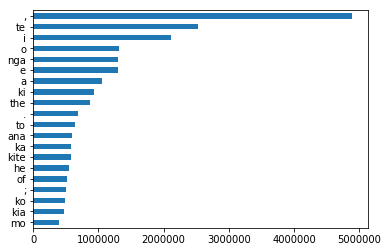

In [10]:
plot_word_frequencies(
    [' '.join(ng) for ng in ngram_list], 
    stop_words = [], 
    num_terms=20
)

## Gensim

We will use the `gensim` library to analyse the text further.

In [11]:
from gensim.models.phrases import Phrases
from gensim.models.word2vec import LineSentence

In [12]:
papers_sents_file = '../data/papers_sents.txt'
with open(papers_sents_file, 'w', encoding = 'utf-8') as f:
    for sent in papers['sentence']:
        f.write(sent + '\n')

In [13]:
unigram_sentences = LineSentence(papers_sents_file)

In [14]:
for unigram_sentence in it.islice(unigram_sentences, 230, 240):
    print(u' '.join(unigram_sentence))
    print(u'')

te rite ai nga Hahi Maori ki nga Ilahi Pakeha?

Ahearanei?

He aha ranei i nui ai te wliakaaroo tetahi, i koreai lo telalii?

Ekore hoki e ahei le mea, he hua no te moni o te Pakeha, he kore to te Maori.

TS T a te aha i hua ai to te Pakeha?

?sa tona uaua.

Na te aha i kore ai to le Maori ?

IVa tona nine noa ilio.

He aha hoki i nui ai te whika o telalii Ilahi i hoki iho ai to tetahi?

lie hua no te hircne i Kaipara i nui ake ai to ratou kohikohinga?



In [15]:
%%time
bigram_model_filepath = '../models/papers_bigrams.model'

if from_scratch or not os.path.exists(bigram_model_filepath):

    bigram_model = Phrases(unigram_sentences)

    bigram_model.save(bigram_model_filepath)
    
else:
    # load the finished model from disk
    bigram_model = Phrases.load(bigram_model_filepath)

CPU times: user 3.63 s, sys: 360 ms, total: 3.99 s
Wall time: 4.01 s


In [16]:
%%time
bigram_sentences_filepath = '../data/bigram_sentences_all.txt'
if from_scratch or not os.path.exists(bigram_sentences_filepath):
    
    with open(bigram_sentences_filepath, 'w', encoding = 'utf-8') as f:    
        for unigram_sentence in unigram_sentences:
            bigram_sentence = u' '.join(bigram_model[unigram_sentence])
            f.write(bigram_sentence + '\n')

CPU times: user 47 µs, sys: 0 ns, total: 47 µs
Wall time: 51.5 µs


In [17]:
bigram_sentences = LineSentence(bigram_sentences_filepath)

In [18]:
trigram_model_filepath = '../models/papers_trigrams.model'
trigram_sentences_filepath = '../data/trigram_sentences_all.txt'

In [19]:
if from_scratch or not os.path.exists(trigram_model_filepath):
    trigram_model = Phrases(bigram_sentences)
    trigram_model.save(trigram_model_filepath)
else:
    # load the finished model from disk
    trigram_model = Phrases.load(trigram_model_filepath)

In [20]:
for bigram_sentence in it.islice(bigram_sentences, 230, 240):
    print(' '.join(bigram_sentence))

In [21]:
%%time
if from_scratch or not os.path.exists(trigram_sentences_filepath):
    with open(trigram_sentences_filepath, 'w') as f:
        for bigram_sentence in bigram_sentences:
            trigram_sentence = u' '.join(trigram_model[bigram_sentence])
            f.write(trigram_sentence + '\n')

CPU times: user 2.34 ms, sys: 0 ns, total: 2.34 ms
Wall time: 1.92 ms


In [22]:
trigram_sentences = LineSentence(trigram_sentences_filepath)

In [24]:
len(list(trigram_sentences))

15

In [25]:
for trigram_sentence in it.islice(trigram_sentences, 0, 15):
    print(' '.join(trigram_sentence))
    print('')

WANTKD, a smart LAD, ' and n rite.

Apply ai Zi alamli'i" Office.

KO_TE KAI-WHAKAMATAARA_O NGA_IWI ERUA.

"Na te Tika i toa_ai."

Turei, Huri 17, 1848.

He korero tenei, no tetahi o o koutou hoa mo o koutou mahinga.

He_tini nga walii o Nu_Tireni kua mania e te Pakelia, lie tini nga rakau o nga ni;aherehere kua kania, kua hanga hei vvliare, hci kaipuke.

Ko tenei ia he korero mo n ,,f a walii o te tangata_maori.

He_nui to koutou vvhenua, nga wahi p:ii, mourona, lie nui nga ngaherehere, be tini nga awaawa, hei ahaunake enei i to koutou mahi kuware?

Ein ihia ana o koutou whenua, e kore ia e riro ake tana kaha.

E ketuketua kautia ana tetalii_walii nohinohi, ki konei tttahi wain, ki koatu.

Kotahi anake tau e noho ai ki tenei walii, ka maliue ka neke liaere ke walii ke tvhakarerunana to koutou mahinga taiepa me nga whare kia ngaliorohoro noa, marara_ke nga tangata, tetalii ki tetalii walii, tetalii ki tetahi_wahi mahiai, waiho amuri hei ketunga mo te poaka.

Nui noa to koutou mahi, hol

## Training word vectors

Here I'll train some word vectors based on the Te Ara Corpus.

In [31]:
from multiprocessing import cpu_count

In [28]:
from gensim.models import Word2Vec

trigram_sentences = LineSentence(trigram_sentences_filepath)
word2vec_filepath = '../models/papers_word2vec.model'

In [29]:
def count_sentences(line_sentence):
    line_count = 0
    for line in line_sentence:
        line_count += 1
    return line_count

In [32]:
%%time
if from_scratch or not os.path.exists(word2vec_filepath):

    # initiate the model and perform the first epoch of training
    reo2vec = Word2Vec(trigram_sentences, size=100, window=5,
                        min_count=20, sg=1, workers=cpu_count()-1)

    # perform 10 epochs of training
    reo2vec.train(
        trigram_sentences,
        total_examples = count_sentences(trigram_sentences), 
        epochs = 10)

    reo2vec.save(word2vec_filepath)
else:
    # load the finished model from disk
    reo2vec = Word2Vec.load(word2vec_filepath)
    reo2vec.init_sims()

RuntimeError: you must first build vocabulary before training the model

In [65]:
reo2vec.wv.most_similar("")

[('atu', 0.5478876233100891),
 ('ake', 0.48823514580726624),
 ('ka', 0.4854778051376343),
 ('ki', 0.4788702726364136),
 ('i', 0.46540868282318115),
 ('whakapaparanga', 0.44860488176345825),
 ('iho', 0.4477006196975708),
 ('tata_paunga', 0.4467763304710388),
 ('aoake', 0.4465719163417816),
 ('kāti', 0.44309982657432556)]

# Visualising the word vectors

Now that we've trained a collection of word vectors, we can visualise them with the common dimensionality reduction algorithms.

In [40]:
from sklearn.manifold import TSNE

In [41]:
# build a list of the terms, integer indices,
# and term counts from the food2vec model vocabulary
ordered_vocab = [(term, reo2vec.wv.vocab[term].index, reo2vec.wv.vocab[term].count)
                 for term in reo2vec.wv.vocab]

# sort by the term counts, so the most common terms appear first
ordered_vocab = sorted(ordered_vocab, key=lambda vocab: -vocab[-1])

# unzip the terms, integer indices, and counts into separate lists
ordered_terms, term_indices, term_counts = zip(*ordered_vocab)

# create a DataFrame with the food2vec vectors as data,
# and the terms as row labels
word_vectors = pd.DataFrame(reo2vec.wv.vectors_norm[term_indices, :],
                            index=ordered_terms)

word_vectors.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
te,-0.222786,0.008506,-0.159120,0.007774,0.029601,0.056520,0.019358,-0.039438,-0.107228,0.003269,...,-0.028638,-0.091592,0.035743,-0.107965,0.040518,0.187595,-0.059293,0.013830,-0.130743,-0.051073
i,-0.178271,0.007903,-0.186632,-0.004492,0.038849,0.019271,0.047945,-0.163053,0.023553,0.117416,...,-0.059919,-0.070771,-0.080721,-0.045064,0.029262,0.025555,-0.031239,-0.108634,-0.084195,0.028562
o,-0.132126,0.090262,-0.097263,-0.045000,0.075789,0.007335,0.010829,-0.024595,0.000504,0.130633,...,-0.056956,-0.042168,-0.189204,-0.076717,0.016934,0.029308,-0.011539,0.067284,-0.026894,0.081146
ngā,-0.189056,-0.086637,-0.194186,-0.052207,-0.058781,0.073729,-0.077801,0.052055,-0.023090,0.125136,...,-0.141133,-0.162282,0.117313,-0.050744,0.013293,-0.016623,-0.127900,0.039982,-0.124890,-0.148520
ki,-0.130063,0.065038,-0.212348,-0.135235,0.047919,0.123008,-0.050220,0.027695,-0.093777,0.097687,...,-0.010310,-0.042633,-0.159101,0.077639,0.042593,0.070596,-0.065038,-0.009395,0.022219,-0.054999


In [42]:
dist_matrix = pd.DataFrame(
    np.matmul(word_vectors.values, word_vectors.values.transpose()),
    columns=word_vectors.index, index = word_vectors.index)

In [43]:
dist_matrix['word'] = dist_matrix.index
dist_matrix = dist_matrix.reset_index(drop=True)
dist_matrix = dist_matrix[['word'] + list(dist_matrix.columns)[:-1]]

In [44]:
dist_matrix.to_csv("../data/dist_matrix.csv", index = False)

In [45]:
dist_matrix.head()

,word,te,i,o,ngā,ki,a,ka,ko,e,...,hinematioro,kāenga,matutaera,hemonga,kupu_whakaari,mihikitekapua,pātiti,maharaia,mātāpono_tiriti,wai_ngārahu
0,te,1.000000,0.628271,0.638123,0.618064,0.544520,0.433727,0.448624,0.386931,0.398505,...,0.292715,0.267812,0.354860,0.295029,0.300009,0.217460,0.348734,0.336682,0.329291,0.153970
1,i,0.628271,1.000000,0.618741,0.483214,0.629857,0.537903,0.496184,0.361675,0.474900,...,0.131130,0.340617,0.370729,0.363631,0.365941,0.247887,0.360679,0.319115,0.346018,0.099930
2,o,0.638123,0.618741,1.000000,0.462891,0.542783,0.396102,0.368187,0.500693,0.315246,...,0.235256,0.257259,0.259257,0.349017,0.253149,0.227215,0.264591,0.179456,0.187651,0.061806
3,ngā,0.618064,0.483214,0.462891,1.000000,0.430483,0.371863,0.354579,0.270213,0.396113,...,0.112666,0.190411,0.187832,0.162474,0.264946,0.228867,0.211053,0.299954,0.353003,0.117631
4,ki,0.544520,0.629857,0.542783,0.430483,1.000000,0.518243,0.457895,0.346322,0.410440,...,0.221359,0.334631,0.263795,0.270693,0.224532,0.244343,0.268656,0.257761,0.295939,0.074110


## Word counts

We can quickly assemble some word counts here to use later:

In [46]:
nga_kupu = []
for sent in trigram_sentences:
    for kupu in sent:
        nga_kupu.append(kupu)

In [47]:
word_counts = (pd.Series(nga_kupu)
     .value_counts()
     .pipe(pd.DataFrame)
     .reset_index()
)

word_counts.columns = ['word', 'word_count']

In [48]:
word_counts.head()

,word,word_count
0,te,188333
1,i,116609
2,o,69513
3,ngā,56832
4,ki,56588


## TSNE

In [49]:
tsne_filepath = '../models/te_ara_tsne.model'
tsne_vectors_filepath = '../models/tsne_vectors.npy'

In [51]:
%%time
if from_scratch or not os.path.exists(tsne_filepath) or not os.path.exists(tsne_vectors_filepath):
    
    tsne = TSNE()
    tsne_vectors = tsne.fit_transform(dist_matrix.drop('word', 1).values)
    
    with open(tsne_filepath, 'wb') as f:
        pickle.dump(tsne, f)

    pd.np.save(tsne_vectors_filepath, tsne_vectors)

else:
    with open(tsne_filepath, 'rb') as f:
        tsne = pickle.load(f)
        tsne_vectors = pd.np.load(tsne_vectors_filepath)

CPU times: user 7min 24s, sys: 12.3 s, total: 7min 36s
Wall time: 7min 36s


In [52]:
tsne_vectors = pd.DataFrame(tsne_vectors,
                            index=pd.Index(dist_matrix.word),
                            columns=[u'x_coord', u'y_coord'])

In [53]:
tsne_vectors['word'] = tsne_vectors.index

tsne_vectors.reset_index(drop=True)

tsne_vectors = tsne_vectors.merge(word_counts, how = 'left', on = ['word'])

tsne_vectors = tsne_vectors[['word', 'x_coord', 'y_coord', 'word_count']]

In [54]:
tsne_vectors.to_csv("../data/tsne.csv", index = False)

In [55]:
tsne_vectors.head()

,word,x_coord,y_coord,word_count
0,te,8.306958,1.840340,188333
1,i,8.057685,2.035390,116609
2,o,8.240121,2.187749,69513
3,ngā,8.679026,0.652699,56832
4,ki,7.344255,2.501331,56588


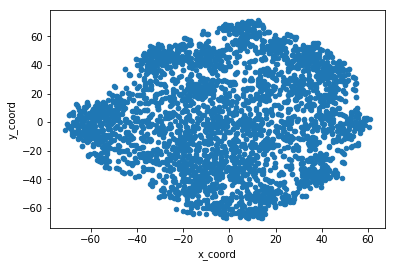

In [56]:
tsne_vectors.plot(kind = 'scatter', x = 'x_coord', y = 'y_coord')

In [57]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource, value
from bokeh.io.export import file_html

output_notebook()

Loading BokehJS ...

In [58]:
# add our DataFrame as a ColumnDataSource for Bokeh
plot_data = ColumnDataSource(tsne_vectors)

# create the plot and configure the
# title, dimensions, and tools
tsne_plot = figure(title=u't-SNE Word Embeddings',
                   plot_width = 800,
                   plot_height = 800,
                   tools= (u'pan, wheel_zoom, box_zoom,'
                           u'box_select, reset'),
                   active_scroll=u'wheel_zoom')

# add a hover tool to display words on roll-over
tsne_plot.add_tools( HoverTool(tooltips = u'@word') )

# draw the words as circles on the plot
tsne_plot.circle(u'x_coord', u'y_coord', source=plot_data,
                 color=u'blue', line_alpha=0.2, fill_alpha=0.1,
                 size=10, hover_line_color=u'black')

# configure visual elements of the plot
tsne_plot.title.text_font_size = value(u'16pt')
tsne_plot.xaxis.visible = False
tsne_plot.yaxis.visible = False
tsne_plot.grid.grid_line_color = None
tsne_plot.outline_line_color = None

# engage!
show(tsne_plot);

# UMAP clustering

In [59]:
umap_filepath = '../models/te_ara_umap.model'
umap_vectors_filepath = '../models/umap_vectors.npy'

In [60]:
%%time

if from_scratch or not os.path.exists(umap_filepath):
    
    umap = UMAP()
    umap_vectors = umap.fit_transform(dist_matrix.values)
    
    with open(umap_filepath, 'wb') as f:
        pickle.dump(umap, f)

    pd.np.save(umap_vectors_filepath, umap_vectors)

else:
    with open(umap_filepath, 'rb') as f:
        tsne = pickle.load(f)

umap_vectors = pd.np.load(umap_vectors_filepath)

umap_vectors = pd.DataFrame(umap_vectors,
                            index=pd.Index(dist_matrix.index),
                            columns=[u'x_coord', u'y_coord'])

umap_vectors['word'] = umap_vectors.index

CPU times: user 31.4 ms, sys: 104 ms, total: 135 ms
Wall time: 235 ms


In [61]:
umap_vectors.reset_index(drop=True).to_csv("../data/umap.csv", index = False)

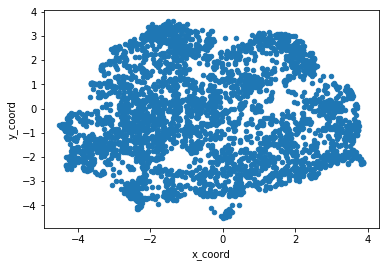

In [62]:
umap_vectors.plot(kind = 'scatter', x = 'x_coord', y = 'y_coord')

In [63]:
# add our DataFrame as a ColumnDataSource for Bokeh
plot_data = ColumnDataSource(umap_vectors)

# create the plot and configure the
# title, dimensions, and tools
umap_plot = figure(title=u'UMAP Word Embeddings',
                   plot_width = 800,
                   plot_height = 800,
                   tools= (u'pan, wheel_zoom, box_zoom,'
                           u'box_select, reset'),
                   active_scroll=u'wheel_zoom')

# add a hover tool to display words on roll-over
umap_plot.add_tools( HoverTool(tooltips = u'@word') )

# draw the words as circles on the plot
umap_plot.circle(u'x_coord', u'y_coord', source=plot_data,
                 color=u'blue', line_alpha=0.2, fill_alpha=0.1,
                 size=10, hover_line_color=u'black')

# configure visual elements of the plot
umap_plot.title.text_font_size = value(u'16pt')
umap_plot.xaxis.visible = False
umap_plot.yaxis.visible = False
umap_plot.grid.grid_line_color = None
umap_plot.outline_line_color = None

# engage!
show(umap_plot);